# Model Stacking for Heart Disease Prediction

## Project Overview
This notebook demonstrates an advanced **ensemble stacking** approach for heart disease prediction. We combine multiple base learners (XGBoost, Random Forest, Logistic Regression) with a meta-learner to achieve superior performance.

### Key Concepts:
- **Stacking**: Combining predictions from multiple models using a meta-learner
- **Feature Engineering**: Creating domain-specific cardiovascular features
- **Pipeline Architecture**: Preventing data leakage and ensuring reproducibility
- **Hyperparameter Tuning**: Optimizing all model components

## 1. Import Required Libraries

Import all necessary libraries for data manipulation, modeling, and visualization.

In [325]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import time
import warnings

# Machine Learning - Model Selection and Validation
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score

# Machine Learning - Models
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Machine Learning - Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Machine Learning - Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, precision_recall_curve, auc,
    log_loss, matthews_corrcoef, cohen_kappa_score,
    average_precision_score
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
warnings.filterwarnings('ignore')
np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [326]:
# Load dataset
data = pd.read_csv('../datasets/heart.csv')
df = data.copy()

# Display basic information
print("Dataset Shape:", data.shape)
print("\nFirst 5 rows:")
print(data.head())

print("\nDataset Info:")
data.info()

print("\nMissing Values:")
print(data.isnull().sum())

print("\nTarget Distribution:")
print(data['HeartDisease'].value_counts())

Dataset Shape: (918, 12)

First 5 rows:
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
--

### Load and Explore Dataset
Load the heart disease dataset and display basic information about its structure, missing values, and target distribution.

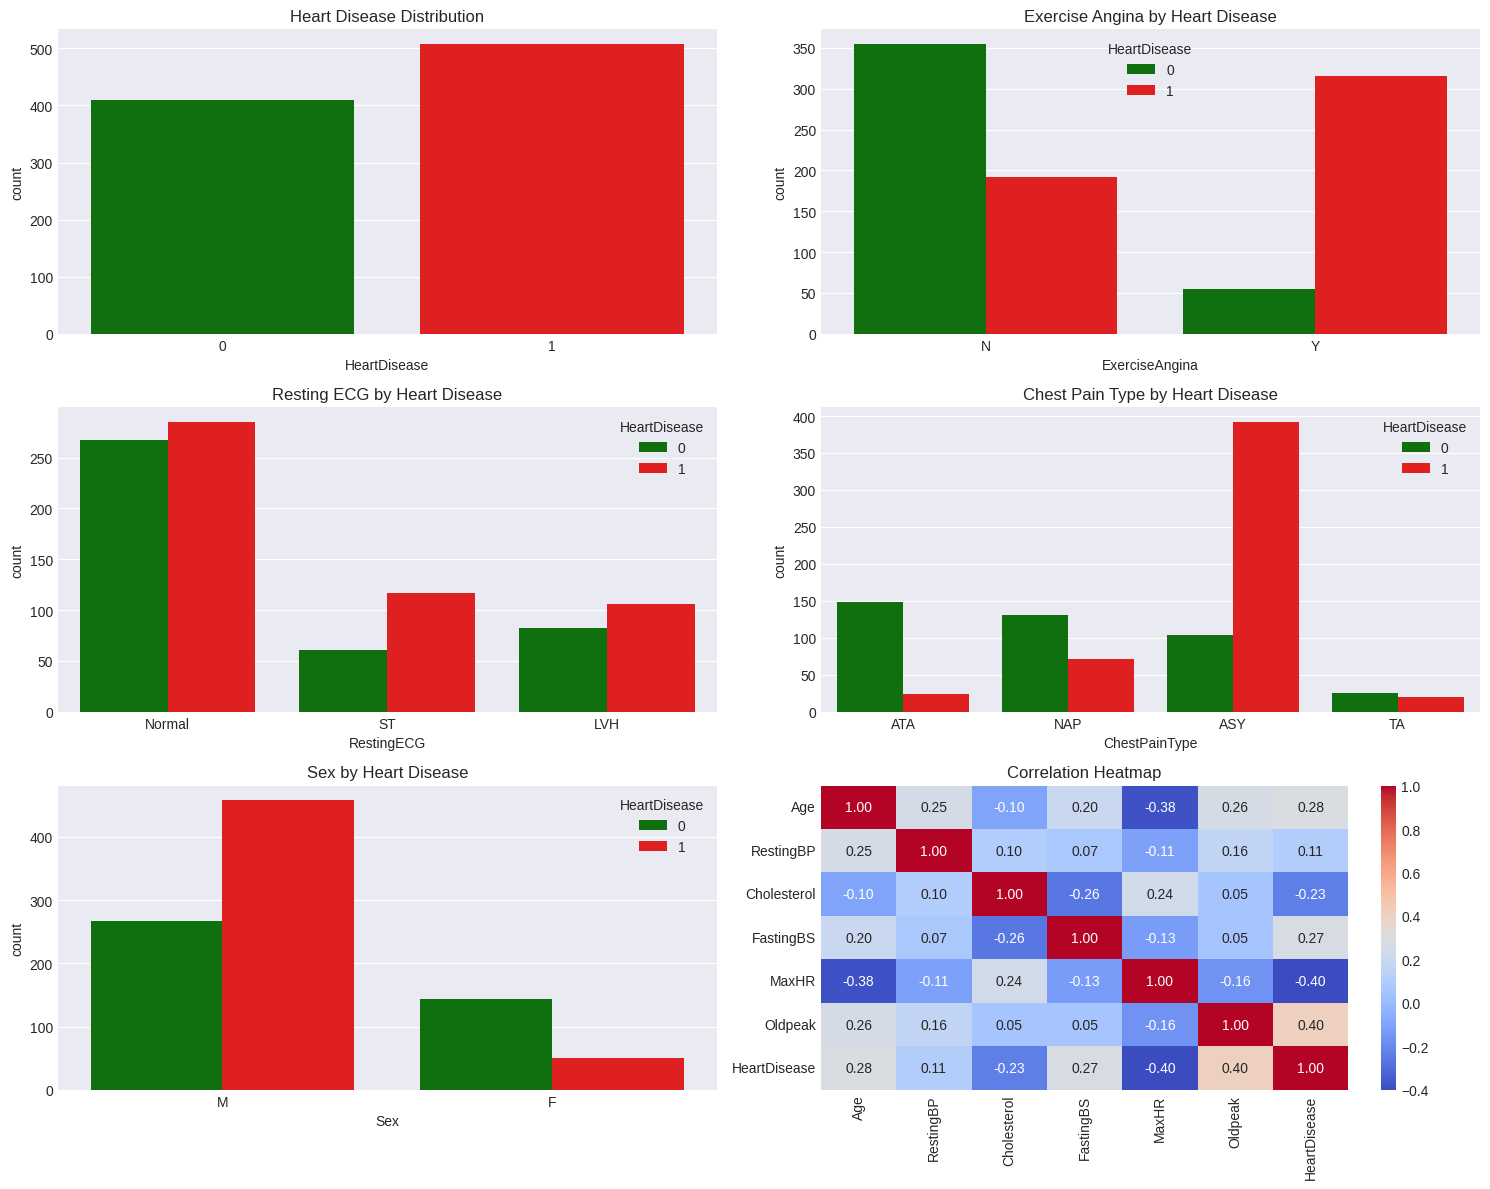

In [327]:
# Visualize data patterns
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
colors = ['green', 'red']

# Target distribution
sns.countplot(x='HeartDisease', data=data, palette=colors, ax=axes[0, 0])
axes[0, 0].set_title('Heart Disease Distribution')

# Exercise Angina
sns.countplot(x='ExerciseAngina', hue='HeartDisease', data=data, palette=colors, ax=axes[0, 1])
axes[0, 1].set_title('Exercise Angina by Heart Disease')

# Resting ECG
sns.countplot(x='RestingECG', hue='HeartDisease', data=data, palette=colors, ax=axes[1, 0])
axes[1, 0].set_title('Resting ECG by Heart Disease')

# Chest Pain Type
sns.countplot(x='ChestPainType', hue='HeartDisease', data=data, palette=colors, ax=axes[1, 1])
axes[1, 1].set_title('Chest Pain Type by Heart Disease')

# Sex distribution
sns.countplot(x='Sex', hue='HeartDisease', data=data, palette=colors, ax=axes[2, 0])
axes[2, 0].set_title('Sex by Heart Disease')

# Correlation heatmap
corr = data.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', ax=axes[2, 1])
axes[2, 1].set_title('Correlation Heatmap')

plt.tight_layout()
plt.show()

### Exploratory Data Analysis Visualizations
Create visualizations to understand the relationships between features and heart disease.

## 2. Data Loading and Exploratory Analysis

Load the Heart Disease dataset and visualize key patterns including target distribution, feature relationships, and correlations.

In [328]:
# Define feature types
binary_features = ['Sex', 'ExerciseAngina']
multi_categorical_features = ['ChestPainType', 'RestingECG', 'ST_Slope']
numeric_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

# Create preprocessing pipelines
numerical_pipeline = Pipeline([('scaler', StandardScaler())])
binary_pipeline = Pipeline([('ordinal', OrdinalEncoder())])
categorical_pipeline = Pipeline([('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numeric_features),
    ('bin', binary_pipeline, binary_features),
    ('cat', categorical_pipeline, multi_categorical_features)
])

# Split data
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define base learners
base_learners = [
    ('xgb', XGBClassifier(random_state=42, eval_metric='logloss')),
    ('rf', RandomForestClassifier(random_state=42)),
    ('lr', LogisticRegression(solver='liblinear', random_state=42))
]

# Create stacking classifier
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(solver='liblinear', random_state=42),
    passthrough=True,
    cv=skf,
    n_jobs=-1
)

# Build and train pipeline
baseline_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', stacking_clf)
])

print("Training baseline model...")
baseline_pipeline.fit(X_train, y_train)

# Evaluate
y_pred = baseline_pipeline.predict(X_test)
y_proba = baseline_pipeline.predict_proba(X_test)[:, 1]

print(f"Baseline Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Baseline ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")

Training baseline model...


/home/manousos/anaconda3/envs/my_env/lib/python3.11/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/manousos/anaconda3/envs/my_env/lib/python3.11/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2

Baseline Accuracy: 0.8859
Baseline ROC-AUC: 0.9320


### Build Baseline Stacking Model
Create preprocessing pipelines and train the baseline stacking classifier.

## 4. Advanced Feature Engineering with Overfitting Prevention

Create comprehensive cardiovascular-specific features while implementing regularization techniques to prevent overfitting.

In [329]:
def engineer_features(X):
    """
    Create cardiovascular-specific features based on medical domain knowledge.
    Focused on the most important interactions and risk indicators.
    """
    X = X.copy()

    # Normalize key metrics by age to capture age-related risk
    X['Chol_Age_Ratio'] = X['Cholesterol'] / (X['Age'] + 1)
    X['MaxHR_Age_Ratio'] = X['MaxHR'] / (X['Age'] + 1)
    X['RestingBP_Age_Ratio'] = X['RestingBP'] / (X['Age'] + 1)
    X['Oldpeak_Age_Ratio'] = X['Oldpeak'] / (X['Age'] + 1)
    X['Oldpeak_MaxHR_Ratio'] = X['Oldpeak'] / (X['MaxHR'] + 1)
    X['RestingBP_MaxHR_Ratio'] = X['RestingBP'] / (X['MaxHR'] + 1)

    # Capture combined effects of multiple risk factors
    X['BP_Chol_Interaction'] = X['RestingBP'] * X['Cholesterol']
    X['Age_MaxHR_Product'] = X['Age'] * X['MaxHR']
    X['Age_Chol_Product'] = X['Age'] * X['Cholesterol']
    X['MaxHR_Oldpeak_Product'] = X['MaxHR'] * X['Oldpeak']
 
    # Clinical metrics based on cardiology guidelines
    X['Heart_Rate_Reserve'] = 220 - X['Age'] - X['MaxHR']  # Cardiac capacity
    X['BP_Risk_Score'] = X['RestingBP'] / 120  # BP normalized to normal (120)
    X['Chol_Risk_Score'] = X['Cholesterol'] / 200  # Chol normalized to desirable (200)
    X['Exercise_Capacity'] = X['MaxHR'] / (220 - X['Age'] + 1)  # Exercise performance
    X['Cardiac_Risk_Score'] = (X['Age']/100 + X['RestingBP']/200 + 
                               X['Cholesterol']/400 - X['MaxHR']/200 + X['Oldpeak']/10)
    
    # Capture non-linear relationships
    X['Age_Squared'] = X['Age'] ** 2
    X['Oldpeak_Squared'] = X['Oldpeak'] ** 2
    X['Log_Cholesterol'] = np.log1p(X['Cholesterol'])

    # Medical guideline-based groupings
    X['Age_Group'] = pd.cut(X['Age'], bins=[0, 45, 60, 100], labels=False).fillna(1).astype(int)
    X['Chol_Category'] = pd.cut(X['Cholesterol'], bins=[0, 200, 240, 600], labels=False).fillna(1).astype(int)
    
    return X

# Create feature engineering transformer
feature_engineer = FunctionTransformer(engineer_features, validate=False)

# List engineered features (20 total - simplified from 33)
engineered_feature_names = [
    # Age-normalized (6)
    'Chol_Age_Ratio', 'MaxHR_Age_Ratio', 'RestingBP_Age_Ratio', 'Oldpeak_Age_Ratio',
    'Oldpeak_MaxHR_Ratio', 'RestingBP_MaxHR_Ratio',
    # Interactions (4)
    'BP_Chol_Interaction', 'Age_MaxHR_Product', 'Age_Chol_Product', 'MaxHR_Oldpeak_Product',
    # Health Indicators (5)
    'Heart_Rate_Reserve', 'BP_Risk_Score', 'Chol_Risk_Score', 'Exercise_Capacity', 'Cardiac_Risk_Score',
    # Non-linear (3)
    'Age_Squared', 'Oldpeak_Squared', 'Log_Cholesterol',
    # Categories (2)
    'Age_Group', 'Chol_Category'
]

# Complete feature list
numeric_features_fe = numeric_features + engineered_feature_names

In [330]:
# Build pipeline with feature engineering and regularization to prevent overfitting
numerical_pipeline_fe = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor_fe = ColumnTransformer([
    ('num', numerical_pipeline_fe, numeric_features_fe),
    ('bin', binary_pipeline, binary_features),
    ('cat', categorical_pipeline, multi_categorical_features)
])

# 1. XGBoost with regularization
xgb_regularized = XGBClassifier(
    random_state=42, 
    eval_metric='logloss',
    reg_alpha=0.1,      # L1 regularization
    reg_lambda=1.0,     # L2 regularization
    max_depth=4,        # Limit tree depth
    min_child_weight=3, # Require more samples per leaf
    subsample=0.8,      # Sample 80% of data
    colsample_bytree=0.8  # Use 80% of features
)

# 2. RandomForest with regularization
rf_regularized = RandomForestClassifier(
    random_state=42,
    max_depth=15,           # Limit tree depth
    min_samples_split=20,   # Require more samples to split
    min_samples_leaf=4,     # Require more samples per leaf
    max_features='sqrt',    # Limit features per tree
    max_samples=0.8         # Bootstrap 80% of data
)

# 3. Logistic Regression with strong regularization
lr_regularized = LogisticRegression(
    solver='liblinear',
    random_state=42,
    C=0.1,              # Strong regularization (inverse)
    penalty='l2',       # L2 regularization
    max_iter=1000
)

# Regularized base learners
base_learners_fe = [
    ('xgb', xgb_regularized),
    ('rf', rf_regularized),
    ('lr', lr_regularized)
]

# Stacking with regularized meta-learner
stacking_clf_fe = StackingClassifier(
    estimators=base_learners_fe,
    final_estimator=LogisticRegression(
        solver='liblinear', 
        random_state=42,
        C=0.5,          # Moderate regularization for meta-learner
        penalty='l2'
    ),
    passthrough=False,   # Don't pass original features to avoid overfitting
    cv=skf,
    n_jobs=-1
)

# Complete pipeline
complete_pipeline = Pipeline([
    ('feature_engineering', feature_engineer),
    ('preprocessor', preprocessor_fe),
    ('classifier', stacking_clf_fe)
])

## 5. Hyperparameter Optimization with Overfitting Prevention

Optimize model parameters using RandomizedSearchCV while maintaining regularization.

In [331]:
# Simplified parameter grid focused on key regularization parameters
param_grid = {
    # Meta-learner regularization
    'classifier__final_estimator__C': [0.1, 0.5, 1.0],
    
    # XGBoost parameters
    'classifier__xgb__n_estimators': [100, 200],
    'classifier__xgb__max_depth': [3, 4, 5],
    'classifier__xgb__learning_rate': [0.01, 0.05, 0.1],
    'classifier__xgb__reg_alpha': [0, 0.1, 0.5],
    'classifier__xgb__reg_lambda': [1.0, 2.0],
    
    # RandomForest parameters
    'classifier__rf__n_estimators': [100, 200],
    'classifier__rf__max_depth': [10, 15, 20],
    'classifier__rf__min_samples_split': [5, 10],
    'classifier__rf__min_samples_leaf': [2, 4],
    
    # Logistic Regression regularization
    'classifier__lr__C': [0.1, 0.5, 1.0]
}

# Run hyperparameter search
random_search = RandomizedSearchCV(
    estimator=complete_pipeline,
    param_distributions=param_grid,
    n_iter=10,  # Balanced number of iterations
    scoring='roc_auc',
    cv=skf,
    verbose=0,  # 0: silent, 1: progress bar, 2: detailed output
    n_jobs=-1,
    random_state=42,
    return_train_score=True
)

time_start = time.time()
random_search.fit(X_train, y_train)
time_end = time.time()
time_elapsed = time_end - time_start

print(f"Hyperparameter tuning completed in {time_elapsed:.2f} seconds")
print(f"Best CV ROC-AUC: {random_search.best_score_:.4f}")

# Check for overfitting
cv_results = pd.DataFrame(random_search.cv_results_)
best_idx = random_search.best_index_
train_score = cv_results.loc[best_idx, 'mean_train_score']
test_score = cv_results.loc[best_idx, 'mean_test_score']
gap = train_score - test_score

print(f"\n Overfitting Check:")
print(f"   Train: {train_score:.4f} | Test: {test_score:.4f} | Gap: {gap:.4f}")
if gap < 0.02:
    print(f"Excellent - minimal overfitting")
elif gap < 0.05:
    print(f"Good - acceptable overfitting")
else:
    print(f"Warning - high overfitting")

/home/manousos/anaconda3/envs/my_env/lib/python3.11/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/manousos/anaconda3/envs/my_env/lib/python3.11/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2

Hyperparameter tuning completed in 14.89 seconds
Best CV ROC-AUC: 0.9327

 Overfitting Check:
   Train: 0.9799 | Test: 0.9327 | Gap: 0.0471
Good - acceptable overfitting


## 6. Model Evaluation and Performance Analysis

Comprehensive evaluation of the optimized model with multiple metrics and visualizations.

In [332]:
# Get best model and predictions
best_model = random_search.best_estimator_
y_pred_opt = best_model.predict(X_test)
y_proba_opt = best_model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy_opt = accuracy_score(y_test, y_pred_opt)
precision_opt = precision_score(y_test, y_pred_opt)
recall_opt = recall_score(y_test, y_pred_opt)
f1_opt = f1_score(y_test, y_pred_opt)
roc_auc_opt = roc_auc_score(y_test, y_proba_opt)
mcc_opt = matthews_corrcoef(y_test, y_pred_opt)
kappa_opt = cohen_kappa_score(y_test, y_pred_opt)
logloss_opt = log_loss(y_test, y_proba_opt)

# Confusion matrix
cm_opt = confusion_matrix(y_test, y_pred_opt)

# PR curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba_opt)
pr_auc_opt = auc(recall_vals, precision_vals)

# Display results
print("Optimized Model Evaluation")
print(f"Accuracy:  {accuracy_opt:.4f}")
print(f"Precision: {precision_opt:.4f}")
print(f"Recall:    {recall_opt:.4f}")
print(f"F1-Score:  {f1_opt:.4f}")
print(f"ROC-AUC:   {roc_auc_opt:.4f}")

Optimized Model Evaluation
Accuracy:  0.8913
Precision: 0.9020
Recall:    0.9020
F1-Score:  0.9020
ROC-AUC:   0.9369


### Evaluate Optimized Model
Calculate comprehensive performance metrics for the tuned model.

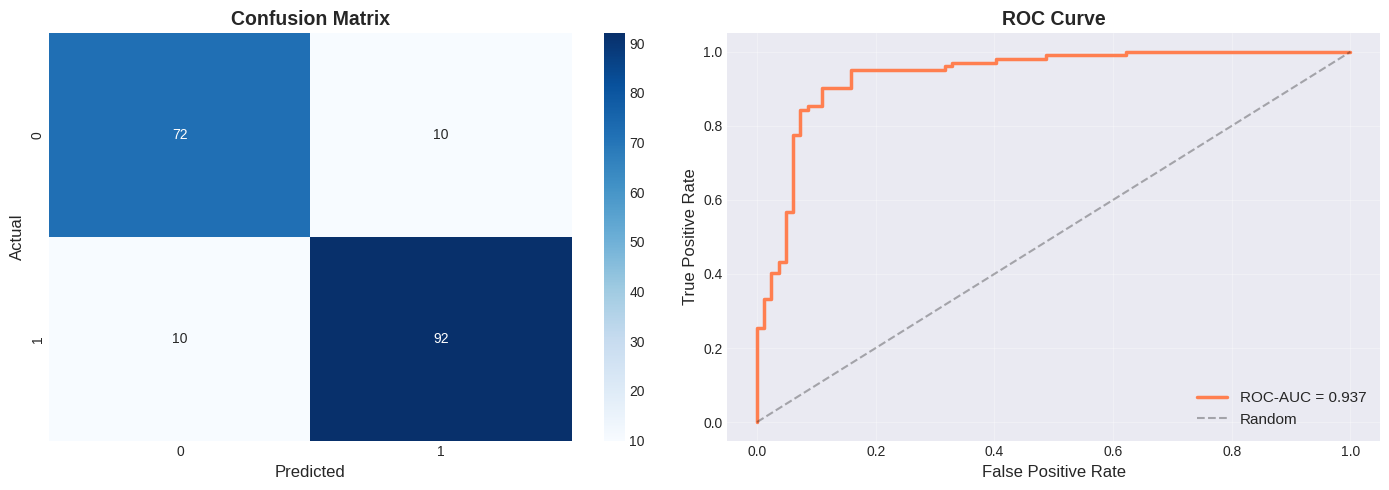

In [333]:
# Create performance visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_xlabel('Predicted', fontsize=12)

# ROC Curve
fpr_opt, tpr_opt, _ = roc_curve(y_test, y_proba_opt)
axes[1].plot(fpr_opt, tpr_opt, label=f'ROC-AUC = {roc_auc_opt:.3f}', linewidth=2.5, color='coral')
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random')
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Visualize Model Performance
Create comprehensive visualizations comparing baseline and optimized models.

## 📊 Baseline vs Optimized Comparison
Compare performance between baseline and optimized models.

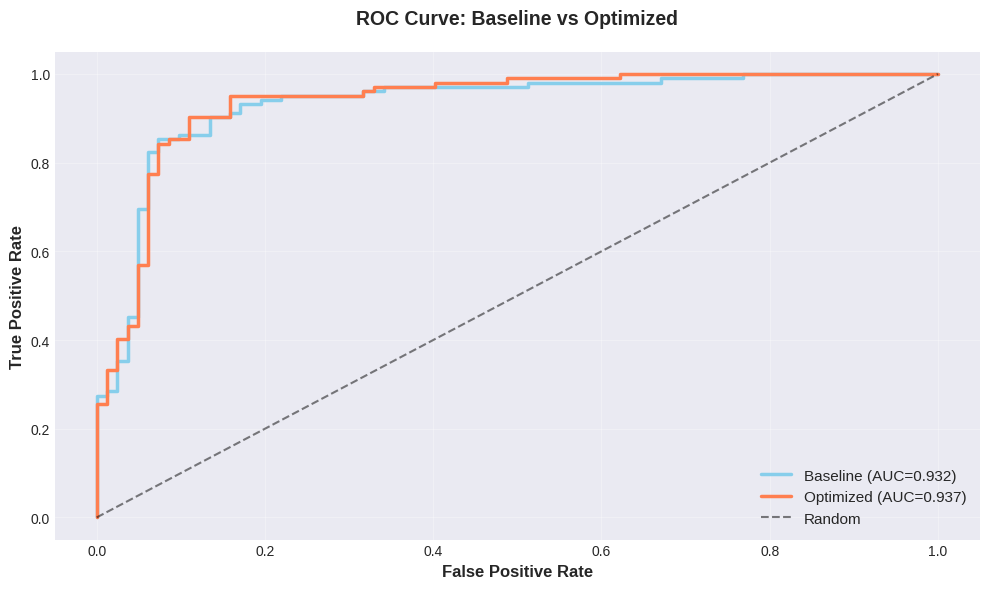


Model Performance Comparison

Metric              Baseline    Optimized       Change
------------------------------------------------------------
Accuracy              0.8859       0.8913      +0.0054
Precision             0.8932       0.9020      +0.0088
Recall                0.9020       0.9020      +0.0000
F1-Score              0.8976       0.9020      +0.0044
ROC-AUC               0.9320       0.9369      +0.0049
MCC                   0.7688       0.7800      +0.0112

✅ Optimized model ROC-AUC: 0.9369


In [334]:
# Calculate baseline metrics
y_pred_baseline = baseline_pipeline.predict(X_test)
y_proba_baseline = baseline_pipeline.predict_proba(X_test)[:, 1]

baseline_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_baseline),
    'Precision': precision_score(y_test, y_pred_baseline),
    'Recall': recall_score(y_test, y_pred_baseline),
    'F1-Score': f1_score(y_test, y_pred_baseline),
    'ROC-AUC': roc_auc_score(y_test, y_proba_baseline),
    'MCC': matthews_corrcoef(y_test, y_pred_baseline),
}

optimized_metrics = {
    'Accuracy': accuracy_opt,
    'Precision': precision_opt,
    'Recall': recall_opt,
    'F1-Score': f1_opt,
    'ROC-AUC': roc_auc_opt,
    'MCC': mcc_opt,
}

# Create simplified comparison visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# ROC Curves Comparison
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_proba_baseline)
fpr_opt, tpr_opt, _ = roc_curve(y_test, y_proba_opt)

ax.plot(fpr_baseline, tpr_baseline, label=f'Baseline (AUC={baseline_metrics["ROC-AUC"]:.3f})', 
        color='skyblue', linewidth=2.5)
ax.plot(fpr_opt, tpr_opt, label=f'Optimized (AUC={optimized_metrics["ROC-AUC"]:.3f})', 
        color='coral', linewidth=2.5)
ax.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1.5, alpha=0.5)

ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curve: Baseline vs Optimized', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison summary
print("\n" + "="*60)
print("Model Performance Comparison")
print("="*60)
print(f"\n{'Metric':<15} {'Baseline':>12} {'Optimized':>12} {'Change':>12}")
print("-"*60)

metrics_to_show = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'MCC']
for metric in metrics_to_show:
    base_val = baseline_metrics[metric]
    opt_val = optimized_metrics[metric]
    change = opt_val - base_val
    print(f"{metric:<15} {base_val:>12.4f} {opt_val:>12.4f} {change:>+12.4f}")

print("="*60)
print(f"\n✅ Optimized model ROC-AUC: {optimized_metrics['ROC-AUC']:.4f}")
print("="*60)

The comparison shows the impact of hyperparameter tuning and feature engineering. The visualization includes metric comparisons, ROC curves, precision-recall curves, and percentage improvements for each metric.

## 7. Feature Importance Analysis

Analyze which features contribute most to predictions using meta-learner coefficients.

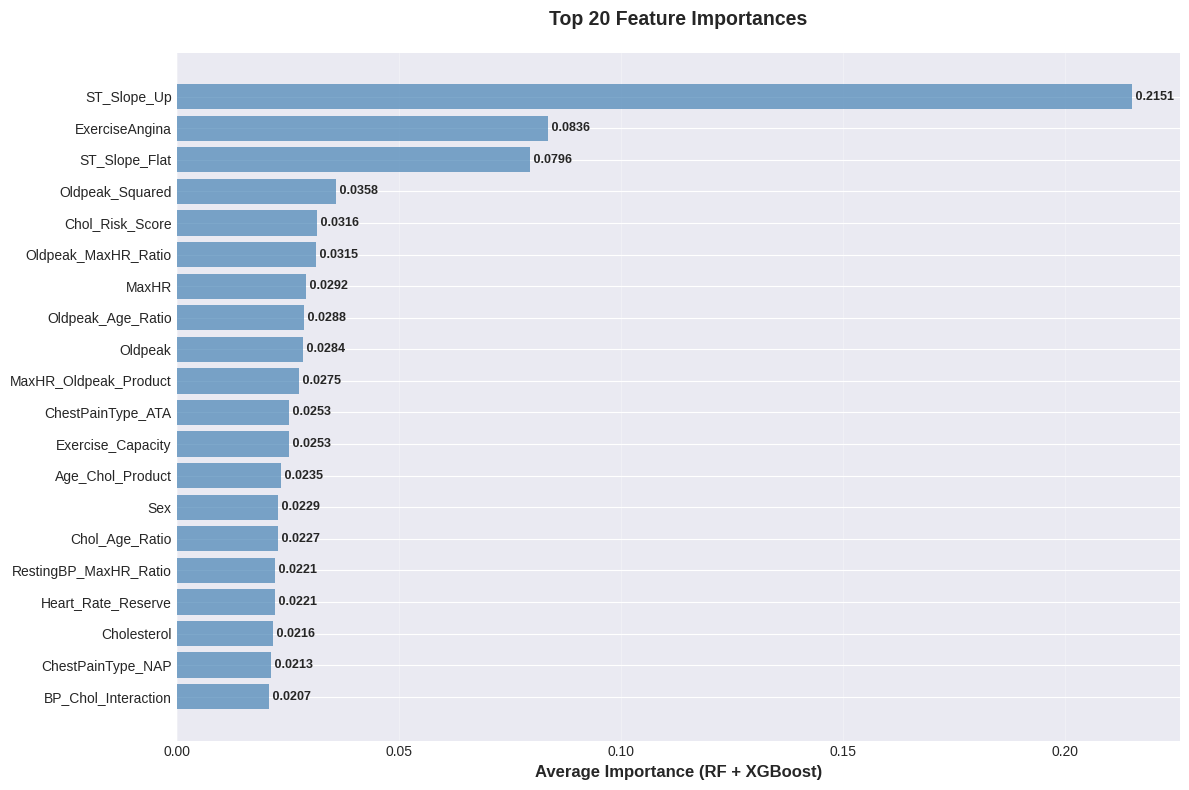

In [335]:
# Get feature importances from Random Forest base model
rf_model = best_model.named_steps['classifier'].named_estimators_['rf']
xgb_model = best_model.named_steps['classifier'].named_estimators_['xgb']

# Get feature names after preprocessing
preprocessor_opt = best_model.named_steps['preprocessor']

# Build complete feature names
all_feature_names = []
all_feature_names.extend(numeric_features_fe)  # All numeric features (original + engineered)
all_feature_names.extend(binary_features)

# Get one-hot encoded categorical feature names
onehot_features = preprocessor_opt.named_transformers_['cat'].named_steps['onehot']
cat_feature_names = onehot_features.get_feature_names_out(multi_categorical_features)
all_feature_names.extend(cat_feature_names)

# Get feature importances from both models
rf_importances = rf_model.feature_importances_
xgb_importances = xgb_model.feature_importances_

# Average the importances
avg_importances = (rf_importances + xgb_importances) / 2

# Create dataframe
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'RF_Importance': rf_importances,
    'XGB_Importance': xgb_importances,
    'Avg_Importance': avg_importances
}).sort_values('Avg_Importance', ascending=False)

# Visualize top 20 features
top_20 = feature_importance_df.head(20)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
y_pos = np.arange(len(top_20))

ax.barh(y_pos, top_20['Avg_Importance'], color='steelblue', alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(top_20['Feature'], fontsize=10)
ax.invert_yaxis()
ax.set_xlabel('Average Importance (RF + XGBoost)', fontsize=12, fontweight='bold')
ax.set_title('Top 20 Feature Importances', fontsize=14, fontweight='bold', pad=20)
ax.grid(alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(top_20.iterrows()):
    ax.text(row['Avg_Importance'], i, f' {row["Avg_Importance"]:.4f}', 
            va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

### Feature Importance Visualization
Visualize which features contribute most to the model's predictions.

## 8. Prediction Confidence and Sample Analysis

Analyze model confidence distribution and examine sample predictions.

Confidence Distribution:
Very High (≥95%): 0 (0.0%)
High (80-95%): 148 (80.4%)
Moderate (60-80%): 30 (16.3%)
Low (<60%): 6 (3.3%)

Sample Predictions:
✓ Patient 19: Pred=1, Prob=78.4%, Actual=1
✓ Patient 42: Pred=1, Prob=93.1%, Actual=1
✓ Patient 156: Pred=0, Prob=10.9%, Actual=0
✓ Patient 111: Pred=0, Prob=20.3%, Actual=0
✓ Patient 148: Pred=1, Prob=88.1%, Actual=1
✓ Patient 15: Pred=1, Prob=94.2%, Actual=1


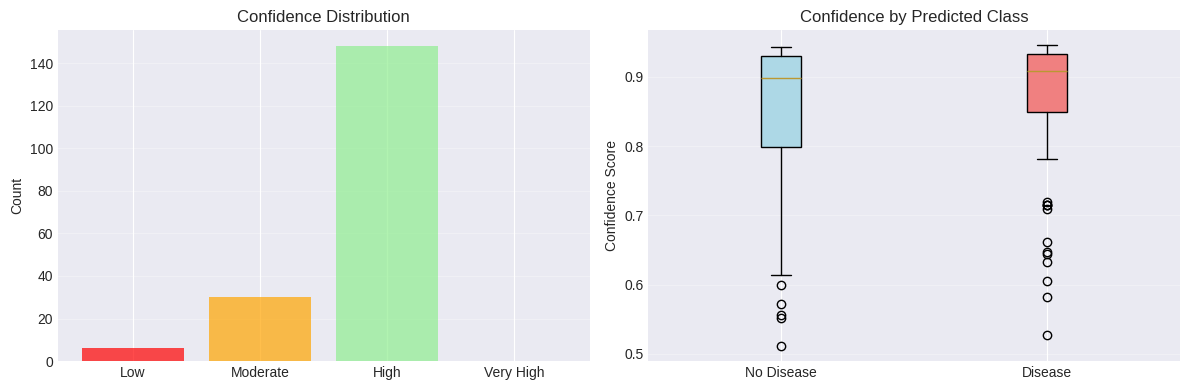

In [336]:
# Get confidence scores
if y_proba_opt.ndim == 1:
    confidence_scores = np.abs(y_proba_opt - 0.5) + 0.5
else:
    confidence_scores = np.max(y_proba_opt, axis=1)

# Calculate confidence distribution
very_high = (confidence_scores >= 0.95).sum()
high = ((confidence_scores >= 0.8) & (confidence_scores < 0.95)).sum()
moderate = ((confidence_scores >= 0.6) & (confidence_scores < 0.8)).sum()
low = (confidence_scores < 0.6).sum()

print("Confidence Distribution:")
print(f"Very High (≥95%): {very_high} ({very_high/len(confidence_scores)*100:.1f}%)")
print(f"High (80-95%): {high} ({high/len(confidence_scores)*100:.1f}%)")
print(f"Moderate (60-80%): {moderate} ({moderate/len(confidence_scores)*100:.1f}%)")
print(f"Low (<60%): {low} ({low/len(confidence_scores)*100:.1f}%)")

# Sample predictions
sample_idx = np.random.choice(len(X_test), 6, replace=False)
print("\nSample Predictions:")
for i in sample_idx:
    actual = y_test.iloc[i]
    pred = y_pred_opt[i]
    prob = y_proba_opt[i, 1] if y_proba_opt.ndim > 1 else y_proba_opt[i]
    status = "✓" if pred == actual else "✗"
    print(f"{status} Patient {i}: Pred={pred}, Prob={prob:.1%}, Actual={actual}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Confidence distribution
conf_labels = ['Low', 'Moderate', 'High', 'Very High']
conf_counts = [low, moderate, high, very_high]
axes[0].bar(conf_labels, conf_counts, color=['red', 'orange', 'lightgreen', 'green'], alpha=0.7)
axes[0].set_ylabel('Count')
axes[0].set_title('Confidence Distribution')
axes[0].grid(alpha=0.3, axis='y')

# Confidence by class
conf_class0 = confidence_scores[y_pred_opt == 0]
conf_class1 = confidence_scores[y_pred_opt == 1]
bp = axes[1].boxplot([conf_class0, conf_class1], labels=['No Disease', 'Disease'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
axes[1].set_ylabel('Confidence Score')
axes[1].set_title('Confidence by Predicted Class')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Confidence Analysis and Sample Predictions
Analyze prediction confidence levels and examine specific sample predictions.